<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/03_01_Creating_training_and_validation_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Training and Validation Dataset Creation with COCO Format

Loads satellite imagery and vector annotations, filters by coverage threshold,
converts polygons to masks, and generates COCO-formatted dataset with train/val splits.

Overview:
    Processes satellite images and tree crown vector annotations, filters valid files
    by coverage percentage, converts polygons to raster masks, and exports datasets
    in COCO format for instance segmentation training.

Main Sections:

    1. Configuration - Load image and vector folders, filter by coverage threshold
    2. Data Loading - Read satellite images and polygon annotations from GeoJSON
    3. Transform Metadata - Extract and store raster transforms and CRS information
    4. Vector to Mask Conversion - Convert polygon geometries to binary mask layers
    5. Image-Mask Pairing - Load and normalize images with corresponding masks
    6. Train/Validation Split - Split dataset 80/20 with random seed
    7. COCO Format Export - Generate train.json and val.json with segmentation data

Key Data:

    Input:
    - Satellite images (.tif format, RGB channels)
    - Vector annotations (GeoJSON with tree crown polygons)
    - Coverage CSV (filters images by coverage > 70%)
    
    Output:
    - COCO format JSON files (train.json, val.json)
    - Image/mask arrays in memory

Processing Parameters:

    - Coverage threshold: 70%
    - Train/validation split: 80/20
    - Image normalization: 0-255 uint8
    - Contour size threshold: 6 pixels minimum

Key Features:

    - Coverage-based file filtering
    - Polygon to raster mask conversion (handles Polygon and MultiPolygon)
    - COCO format with bounding boxes and segmentation polygons
    - Random color map visualization
    - Transform and CRS metadata extraction
    - Support for multiple annotation objects per image

Workflow:

    1. Filter satellite images by coverage threshold from CSV
    2. Load matching images and vector annotations
    3. Convert polygon geometries to instance mask layers
    4. Extract contours and create COCO annotations
    5. Split into train/validation sets
    6. Export as COCO JSON format
"""

# --- Setup ---

In [ ]:
# Check if running in Google Colab
try:
  from google.colab import drive
  running_in_colab = True
except ImportError:
  running_in_colab = False

In [ ]:
if running_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if running_in_colab:
    !pip install --upgrade OWSLib geopandas rasterio shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.1/240.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
from shapely.geometry import Polygon
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.geometry import box
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd
import json
import warnings

# --- Configuration ---

In [ ]:
# Read datasets
data_folder = "/content/drive/MyDrive/data/386_5818/"

satellite_folder = os.path.join(data_folder, 'sliced_output_2020S')
vector_folder = os.path.join(data_folder, 'crowns_cleaned')
coverage_csv_path = os.path.join(data_folder, 'coverage.csv')
transform_matrix_path = os.path.join(data_folder, 'transform_matrix.txt')
transform_json_path = os.path.join(data_folder, 'transform.json')
model_path = os.path.join(data_folder, 'models/')

# Load coverage.csv and filter based on threshold
coverage_df = pd.read_csv(coverage_csv_path, delimiter=';')
valid_files_base = coverage_df[coverage_df['coverage'] > 70]['filename'].tolist()

# Append the extensions for image and vector files
valid_satellite_files = [f + ".tif" for f in valid_files_base]
valid_vector_files = [f + ".geojson" for f in valid_files_base]

# Filter satellite images and vectors based on valid files
satellite_images = [os.path.join(satellite_folder, f) for f in os.listdir(satellite_folder) if f in valid_satellite_files]
vector_layers = {os.path.splitext(f)[0]: os.path.join(vector_folder, f) for f in os.listdir(vector_folder) if f in valid_vector_files}

# Ensure the paths exist
for folder in [model_path, satellite_folder, vector_folder]:
    if not os.path.exists(folder):
        raise FileNotFoundError(f"The folder {folder} does not exist")

# Print valid files vs total files for vector layers
total_geojson_files = len([f for f in os.listdir(vector_folder) if f.endswith(".geojson")])
total_tif_files = len([f for f in os.listdir(satellite_folder) if f.endswith(".tif")])
print(f"{len(vector_layers)} vector files will be used out of {total_geojson_files} total vector files.")


111 vector files will be used out of 400 total vector files.


# --- Processing ---

In [ ]:
transform_data = {}

if satellite_images:
    # Loop through each valid satellite image
    for image_path in satellite_images:
        with rasterio.open(image_path) as src:
            transform = src.transform
            crs = src.crs.to_string()
            bounds = src.bounds
            image_name = os.path.basename(image_path)

            transform_data[image_name] = {
                'transform': list(transform),
                'crs': crs,
                'bounds': bounds,
            }

    # Save all transformation matrices and CRS to a JSON file
    # with open(transform_json_path, 'w') as f:
    #     json.dump(transform_data, f)
    # print(f"Transformation matrices and CRS saved to {transform_json_path}")
else:
    print("No valid satellite images found.")

Transformation matrices and CRS saved to /content/drive/MyDrive/data/400_5816/transform.json


In [ ]:
# Turn the annotation polygons into mask
def vector_to_mask(polygon, image_shape, transform):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    if not polygon.empty:
        for idx, geom in enumerate(polygon):
            if geom is None:
                continue  # Skip this iteration if geom is None
            if geom.type == 'Polygon':

                coords = np.array([geom.exterior.coords])
                coords_reshaped = coords.reshape(-1, 2)
                rows, cols = rasterio.transform.rowcol(transform, coords_reshaped[:, 0], coords_reshaped[:, 1])
                coords_t = np.column_stack((cols, rows)).astype(np.int32)
                cv2.fillPoly(mask, [coords_t], idx+1)
            elif geom.type == 'MultiPolygon':
                for poly_idx, poly in enumerate(geom.geoms):
                    coords = np.array([poly.exterior.coords])
                    coords_reshaped = coords.reshape(-1, 2)
                    rows, cols = rasterio.transform.rowcol(transform, coords_reshaped[:, 0], coords_reshaped[:, 1])
                    coords_t = np.column_stack((cols, rows)).astype(np.int32)
                    cv2.fillPoly(mask, [coords_t], idx+1+poly_idx)
            else:
                raise ValueError('Unknown geometry type: ' + geom.type)
    return mask

In [ ]:
warnings.filterwarnings('ignore')

# Lists to hold image data, masks, and file paths
images = []
masks = []
image_file_names = []
matched = 0

for satellite_image in satellite_images:
    with rasterio.open(satellite_image) as src:
        img = src.read().transpose(1, 2, 0)[:, :, :3]  # Get RGB channels
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        images.append(img)

        # Store the file name for later
        image_file_names.append(satellite_image)

        base_name = os.path.splitext(os.path.basename(satellite_image))[0]
        if base_name in vector_layers:
            vector_layer = vector_layers[base_name]
            polygons = gpd.read_file(vector_layer)
            mask = vector_to_mask(polygons.geometry, img.shape, src.transform)
            matched += 1
        else:
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
        masks.append(mask)

print(f"Number of matched images and masks: {matched}")

Number of matched images and masks: 111


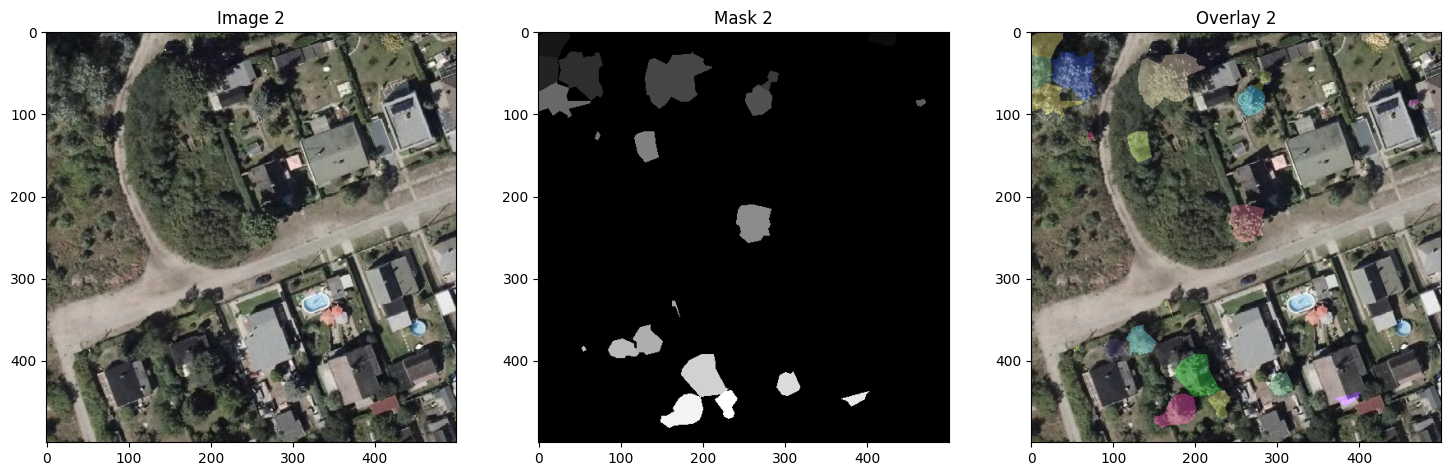

In [ ]:
# Visualize mask layers
def visualize_image_and_mask(image_idx, images, masks):
    def normalize_image(image):
        img_norm = image.copy()
        img_norm = cv2.normalize(img_norm, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        return img_norm

    image = images[image_idx]
    mask = masks[image_idx]

    # Normalize the image and mask
    image_normalized = normalize_image(image)
    mask_normalized = normalize_image(mask)
    #image_normalized = image
    #mask_normalized = mask

    # Create a random color map
    num_labels = np.max(mask_normalized) + 1
    random_color_map = np.random.randint(0, 256, (num_labels, 3), dtype=np.uint8)
    mask_colored = random_color_map[mask_normalized]

    # Set the alpha channel of the mask layer to 0 for the background pixels
    mask_alpha = np.where(mask_normalized == 0, 0, 1)

    # Create an overlay of the colored mask on the image
    overlay = image_normalized.copy()
    mask_colored_alpha = (mask_colored * mask_alpha[..., None]).astype(np.uint8)
    overlay = cv2.addWeighted(image_normalized, 1, mask_colored_alpha, 0.4, 0)

    # Visualize the original image, the mask, and the overlay
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(image_normalized)
    ax1.set_title(f'Image {image_idx}')
    ax2.imshow(mask_normalized, cmap='gray')
    ax2.set_title(f'Mask {image_idx}')
    ax3.imshow(overlay)
    ax3.set_title(f'Overlay {image_idx}')
    plt.show()

# Visualize any image and its mask.  Eg.: 2, 202, 204, 62
visualize_image_and_mask(2, images, masks)

In [ ]:
# Splitting images, masks, and file names into training and validation sets
X_train, X_val, y_train, y_val, train_filenames, val_filenames = train_test_split(
    images, masks, image_file_names, test_size=0.2, random_state=42
)

In [ ]:
print(len(X_train), len(X_val))

88 23


Create COCO dataset - not needed

In [ ]:
def create_coco_format_dataset(images, masks, image_file_names, output_json_path):
    data = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 0, "name": "tree_crown"}]
    }
    annotation_id = 1

    for i, (image, mask) in enumerate(zip(images, masks)):
        height, width, _ = image.shape
        image_file_name = image_file_names[i]

        data["images"].append({
            "id": i,
            "width": width,
            "height": height,
            "file_name": image_file_name
        })

        # Find unique values in the mask (excluding 0 as it is the background)
        unique_values = np.unique(mask)
        unique_values = unique_values[unique_values != 0]

        for unique_value in unique_values:
            # Create a binary mask for the current unique value
            binary_mask = np.uint8(mask == unique_value)

            # Find contours for the binary mask
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                if contour.size < 6:
                    continue  # Skip small contours

                # Flatten the contour and convert it to a list
                contour = np.squeeze(contour)
                segmentation = contour.flatten().tolist()
                bbox = cv2.boundingRect(contour)
                area = cv2.contourArea(contour)

                # Create the annotation dictionary
                annotation = {
                    "id": annotation_id,
                    "image_id": i,
                    "category_id": 0,
                    "segmentation": [segmentation],
                    "bbox": bbox,
                    "area": area,
                    "iscrowd": 0
                }
                data["annotations"].append(annotation)
                annotation_id += 1

    # Write the COCO format dataset to a JSON file
    with open(output_json_path, "w") as f:
        json.dump(data, f, indent=4)

In [ ]:
os.makedirs(data_folder, exist_ok=True)

In [ ]:
create_coco_format_dataset(X_train, y_train, train_filenames, os.path.join(data_folder, "train.json"))
create_coco_format_dataset(X_val, y_val, val_filenames, os.path.join(data_folder, "val.json"))